<a href="https://colab.research.google.com/github/Anjulo/MNIST/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST handwritten digits classification with MLPs

In this notebook, we'll train a multi-layer perceptron model to classify MNIST digits using **PyTorch**. 

First, the needed imports. 

In [ ]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', cuda)

#torch.manual_seed(42)
#if cuda:
#    torch.cuda.manual_seed(42)

## Data

Next we'll load the MNIST data.  First time we may have to download the data, which can take a while.

Note that we are here using the MNIST test data for *validation*, instead of for testing the final model.

In [ ]:
batch_size = 32

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

train_loader = torch.utils.data.DataLoader(
                              datasets.MNIST('../data', train=True, download=True,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])),
                              batch_size=batch_size, shuffle=True, **kwargs
                              )


validation_loader = torch.utils.data.DataLoader(
                                    datasets.MNIST('../data', train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])),
                                    batch_size=batch_size, shuffle=False, **kwargs
                                    )

The train and test data are provided via data loaders that provide iterators over the datasets. The first element of training data (`X_train`) is a 4th-order tensor of size (`batch_size`, 1, 28, 28), i.e. it consists of a batch of images of size 1x28x28 pixels. `y_train` is a vector containing the correct classes ("0", "1", ..., "9") for each training digit.

In [ ]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

Here are the first 10 training digits:

In [ ]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray")
    plt.title(y_train[i])

## MLP network definition

Let's define the network as a Python class.  We have to write the `__init__()` and `forward()` methods, and PyTorch will automatically generate a `backward()` method for computing the gradients for the backward pass.

Finally, we define an optimizer to update the model parameters based on the computed gradients.  We select *stochastic gradient descent (with momentum)* as the optimization algorithm, and set *learning rate* to 0.01.  Note that there are [several different options](http://pytorch.org/docs/optim.html#algorithms) for the optimizer in PyTorch that we could use instead of *SGD*.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 50)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x))

model = Net()
if cuda:
    model.cuda()
    
optimizer = optim.SGD(model.parameters(), lr=0.01)

print(model)

## Learning with Multi-layer perceptron

Let's now define functions to `train()` and `test()` the model. 

In [ ]:
def train(epoch, log_interval=100):
    model.train() # sets the odel mode to training
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
                  #Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.347303
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format( epoch, batch_idx * len(data), len(train_loader.dataset),
                                                                           100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        val_loss += F.nll_loss(output, target).item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))

Now we are ready to train our model using the `train()` function.  An *epoch* means one pass through the whole training data. After each epoch, we evaluate the model using `test()`. 

In [ ]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Let's now visualize how the training progressed. 

* *Loss* is a function of the difference of the network output and the target values.  We are minimizing the loss function during training so it should decrease over time.
* *Accuracy* is the classification accuracy for the test data.

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

##  Learing with simple CNN 
### Make a model in ppt slide

In [ ]:
class SimpleCNN(nn.Module):
    """ConvNet -> Max_Pool -> RELU -> ConvNet -> Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(SimpleCNN, self).__init__()
        #=========TO-DO========
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20,kernel_size=(3,3)) 
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)   
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50,kernel_size=(3,3))
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=50, out_channels=20,kernel_size=(3,3))
        self.fc1 = nn.Linear(in_features=180, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=10)
        #======================

    def forward(self, x):
        #print(x.size())
        x = F.relu(self.conv1(x))
        #print(x.size())
        x = self.maxpool1(x)
        #print(x.size())
        x = F.relu(self.conv2(x))
        #print(x.size())
        x = self.maxpool2(x)
        #print(x.size)
        x = F.relu(self.conv3(x))
        #print(x.size())
        x = x.view(-1, 3*3*20)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
model = SimpleCNN()
if cuda:
    model.cuda()
    
optimizer = optim.SGD(model.parameters(), lr=0.01)

print(model)

In [ ]:
def train_CNN(epoch, log_interval=100):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
def validate_CNN(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        val_loss += F.nll_loss(output, target).item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))

In [ ]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train_CNN(epoch)
    validate_CNN(lossv, accv)

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

##  Learing with VGG like CNN 
### **Let`s make the VGG-like CNN model provided in the ppt slide**

### **VGG network**
- VGG network is a CNN architecture that developed to understand the effect of network depth on performance.
- Although the performance is a bit lower than contemporary architecture of GoogleNet (Inception v1), VGG network is used in various fields than GoogleNet dut to its simple structure.
- Many factors applied to VGG structure influenced the development of the CNN structure later.
  - Mainly utilize 3x3 convolutional layer, and increase the depth of the nerual network, not the kernel size to increase the size of receptive field (size of the area of input image used to compute a pixel of the feature)
  - Utilize padding to prevent changes in the feature size (height, width) in the convolutional layer, and adjust the feature size using pooling layer.
  - Maintain the channel size as $2^n$, and double the channel size 2 times after the pooling layer.

- The figure below is the architecture of VGG network that we use in this experiment.

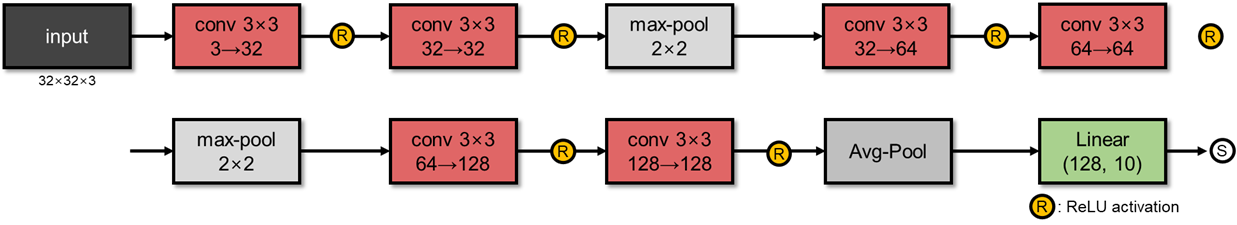

In [ ]:
class SimpleVGG(nn.Module):
    def __init__(self):
        super(SimpleVGG, self).__init__()
        self.act = nn.ReLU()
        self.maxpool2d = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 64, 3, 1, 2)
        self.conv2 = nn.Conv2d(64, 128, 3, 1, 2)
        self.conv3 = nn.Conv2d(128, 256, 3, 1, 2)
        self.conv4 = nn.Conv2d(256, 256, 3, 1, 1)
        self.conv5 = nn.Conv2d(256, 512, 3, 1, 1)
        self.conv6 = nn.Conv2d(512, 512, 3, 1, 1)
        self.conv7 = nn.Conv2d(512, 512, 3, 1, 1)
        self.conv8 = nn.Conv2d(512, 512, 3, 1, 1)
        # Your implementation here
        self.Linear1 = nn.Linear(in_features=512, out_features=128)
        self.drop = nn.Dropout(0.2)
        self.Linear2 = nn.Linear(in_features=128, out_features=64)
        self.last_linear = nn.Linear(in_features=64, out_features=10)
       
    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.maxpool2d(x)
        x = self.act(self.conv2(x))
        x = self.maxpool2d(x)
        x = self.act(self.conv4(self.conv3(x)))
        x = self.maxpool2d(x) 
        x = self.act(self.conv6(self.conv5(x)))        
        x = self.maxpool2d(x)
        x = self.act(self.conv8(self.conv7(x)))
        x = self.maxpool2d(x)
        x = x.view(-1, 512)
        x = self.act(self.Linear1(x))
        x = self.drop(x)
        x = self.act(self.Linear2(x))
        x = self.act(self.last_linear(x))
        return  F.log_softmax(x, dim=1)

In [ ]:
model = SimpleVGG()
if cuda:
    model.cuda()
    
optimizer = optim.SGD(model.parameters(), lr=0.05)

print(model)

In [ ]:
def train_VGG(epoch, log_interval=100):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
def validate_VGG(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        val_loss += F.nll_loss(output, target).item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))

In [ ]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train_VGG(epoch)
    validate_VGG(lossv, accv)

##  Learing with ResNet like CNN 
### Let`s make the ResNet-like CNN model provided in the ppt slide

## **2. Implement a Residual Network (ResNet) using Pytorch**
- Residual Network is a CNN architecture that adopts the skip connection to train the deeper neural networks.
  - Through the skip connection, we can solve the gradient vanishing problem caused by increasing the depth of neural network.
  - Performance is enhanced without additional computational complexity.
- Skip connection enables utilizing the features of lower layers directly in higher layers.
  - Even at a depth similar to the existing neural network archicture (e.g. VGG), skip connection improves performance.
- Batch normalization is also adopted in ResNet.
  - To apply batch normalization to CNN, we use `torch.nn.BatchNorm2d` class.
  - When defining batch normalization layer, we need to input the number of channels as `torch.nn.BatchNorm2d(32)`.
  - We apply the batch normalization between the convolutional layer and activation function.

- In this experiments, You should construct ResNet following the figure below.

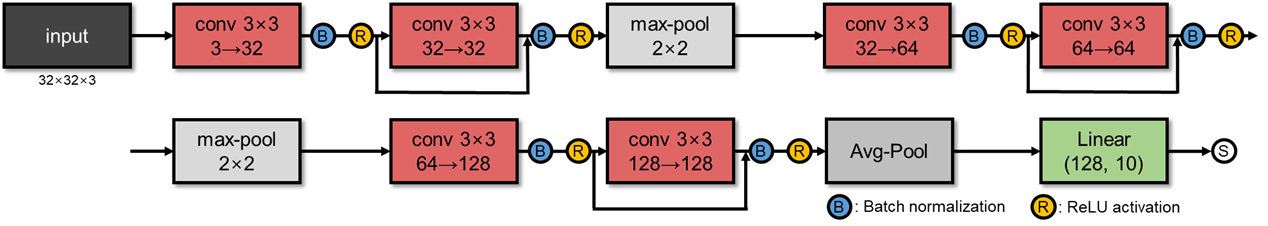

  - You should add the reisudal connections at 2nd, 4th, 6th convolutional layer.
  - You should add the batch normalization layer right after each convolutional layer.

In [ ]:
class ResBlock(nn.Module):
    """
    Residual block
    """
    def __init__(self, in_chs, activation='relu', batch_norm=False):
        super(ResBlock, self).__init__()
    
    def forward(self, x):
        return out

In [ ]:
class SimpleResNet(nn.Module):
    def __init__(self):
        super(SimpleResNet, self).__init__()
        # Your implementation here
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.norm1= nn.BatchNorm2d(32) # Batch normalization layer with channel size = 32.
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.norm2= nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.norm3= nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.norm4= nn.BatchNorm2d(64)

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.norm5= nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.norm6= nn.BatchNorm2d(128)

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size = (1, 1))

        self.fc = nn.Linear(in_features=128, out_features=10)


    def forward(self, x):
        # Your implementation here
          ######### Modify the forward function to utilize skip connection and batch normalization #########

        # Task 1. Add residual connections at conv2, conv4, and conv6 with the same number of input channels and output channels.
        # Task 2. Add the forward propagation through batch normalization layer
        x = F.relu(self.norm1(self.conv1(x)))
        x_residual = x
        x = self.conv2(x) + x_residual
        x = F.relu(self.norm2(x))
        x = self.max_pool(x)

        x = F.relu((self.norm3(self.conv3(x))))
        x_residual = x
        x = self.conv4(x)+ x_residual
        x = F.relu(self.norm4(x))
        x = self.max_pool(x)

        x = F.relu(self.norm5(self.conv5(x)))
        x_residual = x
        x = self.conv6(x)+ x_residual
        x = F.relu(self.norm6(x))
        x = self.max_pool(x)

        x = self.avg_pool(x)
        x = x.view(-1, 128)
        x = self.fc(x)
        #return[x]
        return  F.log_softmax(x, dim=1)

In [ ]:
model = SimpleResNet()
if cuda:
    model.cuda()
    
optimizer = optim.SGD(model.parameters(), lr=0.05)

In [ ]:
def train_ResNet(epoch, log_interval=100):
    # your impelmentation here
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        #loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
def validate_ResNet(loss_vector, accuracy_vector):
    # your impelmentation here
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        val_loss += F.nll_loss(output, target).item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))

In [ ]:
%%time
epochs = 10
lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train_ResNet(epoch)
    validate_ResNet(lossv, accv)